# Загрузка датасета


In [ ]:
# все исправленные датасеты лежать по ссылке https://disk.yandex.ru/d/mEak3w2wbQO3Aw. Для данного ноутбука нужен архивы train_carplate.zip и train_cars

In [ ]:
!unzip train_carplate.zip
!mv train train_carplate
!rm labelmap.txt

In [ ]:
!unzip train_cars.zip
!mv train train_car
!rm labelmap.txt

# Импорт библиотек

In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -r /content/yolov5/requirements.txt

In [ ]:
import os
import shutil
import yaml
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Слияние двух датасетов

In [ ]:
!rm -r /content/train

!mkdir /content/train
!mkdir /content/train/images
!mkdir /content/train/labels

rm: cannot remove '/content/train': No such file or directory


In [ ]:
def reoder_files(car_path, carplate_path, dest_path):
    processed = set()
    bboxes = dict()

    for name in os.listdir(car_path + '/images'):
        txt_name = name.split('.')[0] + '.txt'
        # print(txt_name)
        bboxes[txt_name] = []
        for line in open(car_path + '/labels/' + txt_name).readlines():
            coords = line.split()
            bboxes[txt_name].append('0 ' + ' '.join(coords[1:]))

        shutil.copy(car_path + '/images/' + name, dest_path + '/' + 'images')
        processed.add(name)

    for name in os.listdir(carplate_path + '/images'):
        txt_name = name.split('.')[0] + '.txt'
        if txt_name not in bboxes.keys():
            bboxes[txt_name] = []

        for line in open(carplate_path + '/labels/' + txt_name).readlines():
            coords = line.split()
            bboxes[txt_name].append('1 ' + ' '.join(coords[1:]))

        if name not in processed:
            shutil.copy(carplate_path + '/images/' + name, dest_path + '/' + 'images')
            processed.add(name)
    
    for name in bboxes.keys():
        with open(dest_path + '/labels/' + name, 'w') as f:
            for b in bboxes[name]:
                f.write(b + '\n')

reoder_files('/content/train_car', '/content/train_carplate', '/content/train')

# Разделение на обучающую и валидационную выборки

In [ ]:
!rm -r /content/train_split
!rm -r /content/val_split

!mkdir /content/train_split
!mkdir /content/train_split/images
!mkdir /content/train_split/labels
!mkdir /content/val_split
!mkdir /content/val_split/images
!mkdir /content/val_split/labels

In [ ]:
train_path = '/content/train_split/'
val_path = '/content/val_split/'
source_path = '/content/train/'

names = [s.split('.')[0] for s in os.listdir('/content/train/images')]
train_names, val_names = train_test_split(names, test_size=0.3, random_state=42, shuffle=True)
print(len(train_names), len(val_names))

for name in train_names:
  shutil.copy(os.path.join(os.path.join(source_path, 'images'), f'{name}.jpg'), os.path.join(train_path, 'images'))
  shutil.copy(os.path.join(os.path.join(source_path, 'labels'), f'{name}.txt'), os.path.join(train_path, 'labels'))

for name in val_names:
  shutil.copy(os.path.join(os.path.join(source_path, 'images'), f'{name}.jpg'), os.path.join(val_path, 'images'))
  shutil.copy(os.path.join(os.path.join(source_path, 'labels'), f'{name}.txt'), os.path.join(val_path, 'labels'))


print(len(os.listdir(train_path + 'images')), len(os.listdir(val_path + 'images')))

1325 568
1325 568


(1080, 1920, 3)
[[0.         0.89235156 0.25042593 0.05494271 0.09974074]
 [0.         0.8086276  0.21705093 0.08308854 0.10465741]
 [0.         0.57201823 0.17341667 0.07354687 0.06718519]
 [0.         0.62550781 0.17600463 0.07994271 0.07236111]
 [0.         0.68045312 0.19357407 0.08227083 0.07855556]
 [0.         0.34494271 0.44495833 0.277125   0.19452778]
 [0.         0.03557031 0.20009259 0.04767188 0.04444444]
 [0.         0.45207552 0.15701389 0.07543229 0.05958333]
 [0.         0.2150625  0.18195833 0.05309375 0.05025   ]
 [0.         0.27239583 0.14427315 0.043      0.04450926]
 [0.         0.28905208 0.1422963  0.03876042 0.04916667]
 [0.         0.74077344 0.20236574 0.09070312 0.09406481]
 [0.         0.65059635 0.40322685 0.25117187 0.21700926]
 [0.         0.32498437 0.13852778 0.0710625  0.07035185]
 [0.         0.412875   0.15238426 0.06789583 0.05813889]
 [0.         0.3526849  0.14215741 0.06661979 0.05562963]
 [0.         0.47130469 0.22648148 0.11192187 0.08612963

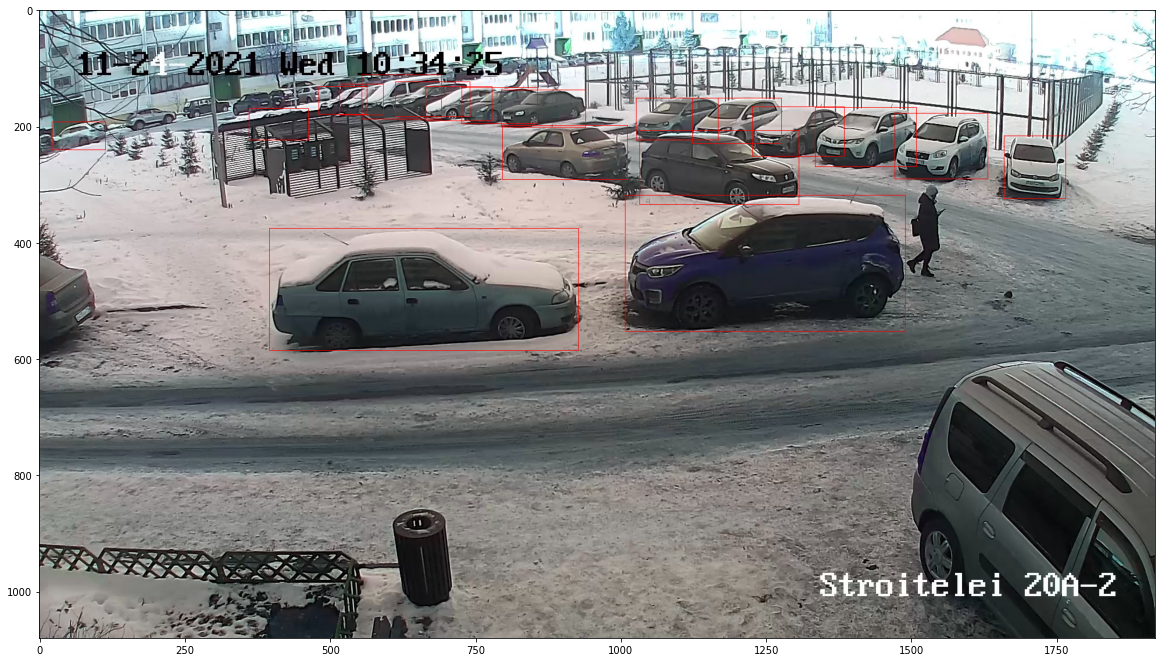

In [ ]:
img_name = '24-11-2021_07-34-27_AM'
img = cv2.imread(f'/content/val_split/images/{img_name}.jpg')
ndf = pd.read_csv(f'/content/val_split/labels/{img_name}.txt', sep=' ', names=['class', 'x', 'y', 'w', 'h'])
data = ndf.to_numpy()
print(img.shape)
if list(ndf.index).count(img_name) == 1:
  data = np.expand_dims(data, axis=0)
print(data)

dh, dw, _ = img.shape

for p in range(len(data)):
    x, y, w, h = float(data[p][1]), float(data[p][2]), float(data[p][3]), float(data[p][4])

    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)

    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1


    cv2.rectangle(img, (l, t), (r, b), (255, 0, 0), 1)

plt.figure(figsize=(20, 30))
plt.imshow(img)

# Создание data.yaml и объявление конфигурации модели

In [ ]:
num_classes = 2
#в папке data_for_yolo создадим dataset.yaml со следующим содержимым

yaml_content = f"""
train: /content/train_split/images
val: /content/val_split/images

# number of classes
nc: {num_classes}

# class names
names: ['car', 'carplate']
"""

names = yaml.safe_load(yaml_content)

with open('/content/data.yaml', 'w') as file:
    yaml.dump(names, file)

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
!cat /content/yolov5/models/yolov5m.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5m.yaml
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple


anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Обучение

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
!python /content/yolov5/train.py --img 1000 --batch 16 --epochs 50 --data /content/data.yaml --cfg /content/yolov5/models/custom_yolov5m.yaml --weights yolov5m.pt --name yolov5m_results  --cache

train: weights=yolov5m.pt, cfg=/content/yolov5/models/custom_yolov5m.yaml, data=/content/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=1000, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-18-geb359c3 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, 

# Инференс

In [ ]:
!gdown https://lodmedia.hb.bizmrg.com/case_files/789899/test_dataset_test.zip

Downloading...
From: https://lodmedia.hb.bizmrg.com/case_files/789899/test_dataset_test.zip
To: /content/test_dataset_test.zip
100% 456M/456M [00:07<00:00, 63.7MB/s]


In [ ]:
!unzip test_dataset_test.zip

In [ ]:
!python3 yolov5/detect.py --weights /content/yolov5/runs/train/yolov5m_results/weights/best.pt --img 1000 --conf 0.4 --source /content/test/images --save-txt --save-conf

detect: weights=['/content/yolov5/runs/train/yolov5s_results2/weights/best.pt'], source=/content/test/images, data=yolov5/data/coco128.yaml, imgsz=[1000, 1000], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.2-18-geb359c3 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5m summary: 290 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
image 1/855 /content/test/images/0_23-11-2021_02-18-50_PM.jpg: 672x1024 1 carplate, 42.6ms
image 2/855 /content/test/images/0_23-11-2021_02-18-56_PM.jpg: 864x1024 1 carplate, 55.1ms
image 3/855 /content/test/images/0_23-11-2021_02-19-19_PM.jpg: 640x1024 1 carplate, 23.5ms
image 4/855 /content/test/images/0_

In [ ]:
def get_soliton_labels_df_simple_solution(path_to_txt_folder):
  simple_solution = []
  for detection_file in os.listdir(path_to_txt_folder):
    img_name = detection_file.split('.')[0] + '.jpg'
    with open(path_to_txt_folder + detection_file, 'r') as f:
      data = f.read()
      data = [i for i in data.split('\n') if i != '']
    for line in data:
      val = [float(i) for i in line.split()]
      cls, xywh, conf = val[0], val[1:5], val[5]
      center_x, center_y, width, height = xywh
      xmin = center_x - (width / 2)
      xmax = center_x + (width / 2)
      ymin = center_y - (height / 2)
      ymax = center_y + (height / 2)

      if cls == 0:
        simple_solution.append([img_name, 0, conf, xmin, xmax, ymin, ymax])
      else:
        simple_solution.append([img_name, 4, conf, xmin, xmax, ymin, ymax])
  return simple_solution

In [ ]:
simple_solution = get_soliton_labels_df_simple_solution('yolov5/runs/detect/exp2/labels/')
simple_solution = pd.DataFrame(simple_solution, columns=['ImageID', 'LabelName', 'Conf', 'XMin', 'XMax', 'YMin', 'YMax'])

In [ ]:
simple_solution

,ImageID,LabelName,Conf,XMin,XMax,YMin,YMax
0,24-11-2021_06-42-28_AM.jpg,0,0.633471,0.969140,1.000000,0.439584,0.609723
1,24-11-2021_06-42-28_AM.jpg,0,0.852159,0.757813,0.850781,0.268056,0.340278
2,24-11-2021_06-42-28_AM.jpg,0,0.937627,0.800391,0.957813,0.628472,0.835416
3,24-11-2021_06-42-28_AM.jpg,0,0.950582,0.607812,0.740234,0.378472,0.523612
4,25-11-2021_06-59-00_PM.jpg,0,0.929821,0.319792,0.424478,0.262962,0.350000
...,...,...,...,...,...,...,...
7618,24-11-2021_07-53-46_AM.jpg,0,0.948439,0.607031,0.739453,0.378472,0.522916
7619,24-11-2021_07-53-46_AM.jpg,0,0.958195,0.753125,0.928125,0.341666,0.621528
7620,24-11-2021_07-53-46_AM.jpg,0,0.966981,0.730859,0.934375,0.690278,0.933334
7621,24-11-2021_12-55-04_PM.jpg,0,0.654973,0.932812,0.998958,0.480556,0.823148


In [ ]:
simple_solution.to_csv("cars_and_carplates_sol.csv", sep=';', index=False)

# отображение предсказаний

(1520, 2688, 3)
[['0' '0.750141' '0.31882390000000005' '0.4151781' '0.1032892'
  '0.1684208']
 ['0' '0.806956' '0.26376505' '0.32440494999999997' '0.08684185'
  '0.14736815']
 ['0' '0.865628' '0.6019346' '0.6767114' '0.10789465' '0.17828935']
 ['0' '0.884661' '0.37351199999999996' '0.564732' '0.2111845'
  '0.40263150000000003']
 ['0' '0.89604' '0.21577349999999998' '0.3549105' '0.18355249999999998'
  '0.32894749999999995']
 ['0' '0.910283' '0.1473219' '0.21317009999999997' '0.1480266'
  '0.24276340000000002']
 ['0' '0.919635' '0.19084774999999998' '0.26078825' '0.17368374999999997'
  '0.27039425']
 ['0' '0.929181' '0.65439035' '0.73735165' '0.12039445' '0.20131555']
 ['0' '0.937363' '0.8061754999999999' '0.9081105' '0.164474' '0.3']
 ['0' '0.944419' '0.7198656999999999' '0.7920383' '0.1539474' '0.2342106']
 ['0' '0.951519' '0.5974705' '0.7135415' '0.16842100000000002'
  '0.28026300000000004']
 ['0' '0.961914' '0.2548365' '0.4029015' '0.2164475'
  '0.37500049999999996']]


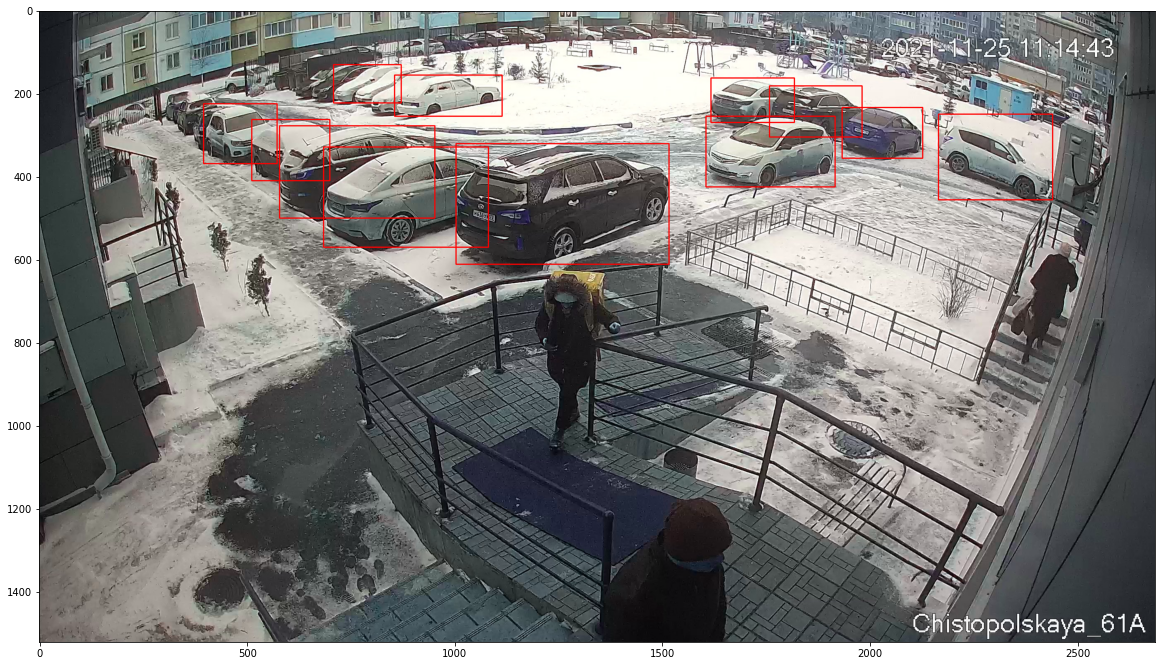

In [ ]:
img_name = '25-11-2021_08-14-45_AM.jpg'
img = cv2.imread(f'./test/images/{img_name}')
ndf = pd.read_csv('cars_and_carplates_sol.csv', sep=';', names=['class', 'conf', 'x', 'y', 'w', 'h'])
data = ndf.loc[img_name].to_numpy()
print(img.shape)
if list(ndf.index).count(img_name) == 1:
  data = np.expand_dims(data, axis=0)
print(data)

dh, dw, _ = img.shape

colors = {0: (255, 0, 0),
          1: (0, 255, 0),
          2: (0, 0, 255),
          3: (255, 255, 0),
          4: (0, 255, 255)}

for p in range(len(data)):
    cls = int(data[p][0])
    x, y, w, h = float(data[p][2]), float(data[p][3]), float(data[p][4]), float(data[p][5])

    l = int(x * dw)
    r = int(y * dw)
    t = int(w * dh)
    b = int(h * dh)

    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1


    cv2.rectangle(img, (l, t), (r, b), colors[cls], 2)

plt.figure(figsize=(20, 30))
plt.imshow(img)